In [1]:
import gc

import numpy as np
import pandas as pd
#import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold #train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge #, RidgeCV
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from custom.preprocessing import (
    preserve_geometry, 
    _add_shrid_to_mosaiks, 
    _merge_mosaiks_and_secc,
    #load_and_merge_data, 
)
from custom.shrug_data import (
    lengthen_shapefile_ID_names, 
    load_shrug_shapefiles, 
    load_shrug_secc,
)
from custom.evaluation import show_results, plot_prediction_maps
from custom.utils import load_gdf, latlon_df_to_gdf

In [2]:
DATA_ROOT = "/home/jovyan/ds_nudge_up/data/"
mosaiks_path = DATA_ROOT+"01_preprocessed/mosaiks_features/"

## Load data

### Mosaiks features (with latlons)

Old API data

In [3]:
# using old data downloaded from the online API
# data_label = "old_v4000"
# filename = "mosaiks_downloaded_old_features_rounded.csv"
# lat_name, lon_name = "Lat", "Lon"

# # Load data
# mosaiks_features = pd.read_csv(mosaiks_path+filename)

2013 data

In [4]:
data_label = "2013_3km_v4000"
filename = '2013_3km_v4000_L8_0_to_96166.parquet.gzip'
lat_name, lon_name = "Lat", "Lon"

# Load data
mosaiks_features = pd.read_parquet(mosaiks_path+filename)
mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features, lat_name=lat_name, lon_name=lon_name)
print("No. points:", mosaiks_features_gdf.shape[0])

mosaiks_features_gdf = mosaiks_features_gdf.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf.shape[0])

No. points: 96167
No. points after dropping NAs: 88898


2021 data

In [5]:
data_label_21 = "2021_3km_v4000"
filename_21 = '2021_3km_v4000_L8_0_to_96166.parquet.gzip'
lat_name, lon_name = "Lat", "Lon"

# Load data
mosaiks_features_21 = pd.read_parquet(mosaiks_path+filename_21)
mosaiks_features_gdf_21 = latlon_df_to_gdf(mosaiks_features_21, lat_name=lat_name, lon_name=lon_name)
print("No. points:", mosaiks_features_gdf_21.shape[0])

mosaiks_features_gdf_21 = mosaiks_features_gdf_21.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf_21.shape[0])

No. points: 96167
No. points after dropping NAs: 87586


SHRUG geometries

In [6]:
shrug_key_geoms = load_gdf(
    "01_preprocessed/SHRUG/shrug_pc11r_key_with_shapes",
    "shrug_pc11r_key_with_shapes.shp",
)
shrug_key_geoms = lengthen_shapefile_ID_names(shrug_key_geoms)
shrug_key_geoms = preserve_geometry(shrug_key_geoms, level="village")

SHRUG SECC

In [7]:
shrug_secc = load_shrug_secc()

Merge Mosaiks featues and SECC target via village shapes

In [8]:
mosaiks_features_gdf = _add_shrid_to_mosaiks(mosaiks_features_gdf, shrug_key_geoms)

In [9]:
gdf = _merge_mosaiks_and_secc(mosaiks_features_gdf, shrug_secc)

In [10]:
del shrug_key_geoms
del shrug_secc
del mosaiks_features
del mosaiks_features_gdf
gc.collect()

0

## Pre-process data

In [11]:
# Select target
y_name = "secc_pov_rate_rural"

In [12]:
# drop rows with unavailable target
gdf_clean = gdf.dropna(subset=y_name)

In [13]:
# select list of columns to drop from the data so only features and target are left
shrug_key_cols = [
    "pc11_state_id",
    "pc11_district_id",
    "pc11_subdistrict_id",
    "pc11_village_id",
    "tv_name",
    "shrid",
    "pc11_v_uid",
    "geometry",
    "geometry_village"
]
geo_cols = [lat_name, lon_name] + shrug_key_cols

shrug_secc_cols = [
    "shrid",
    "secc_inc_cultiv_share",
    "nco2d_cultiv_share",
    "secc_cons_pc_rural",
    "secc_cons_pc_urban",
    "secc_pov_rate_rural",
    "secc_pov_rate_urban",
    "secc_pov_rate_tend_rural",
    "secc_pov_rate_tend_urban",
    "num_members_mean_rural",
    "num_members_mean_urban",
]
shrug_secc_cols.remove(y_name)

cols_to_drop = list(shrug_secc_cols) + geo_cols

In [14]:
# select features and target
X = gdf_clean.drop(cols_to_drop + [y_name], axis=1)
y = gdf_clean[y_name]

Grouped train-test split: making sure that datapoints from the same village don't get split across train and test datasets (to avoid leakage).

Can change grouping variable to larger scale if needed (e.g. unique subdistrict IDs, etc)

In [15]:
# choose train/test indices
grouping_var = "pc11_v_uid"
splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=0)
split = splitter.split(gdf_clean, groups=gdf_clean[grouping_var])
train_index, test_index = list(split)[0]

In [16]:
len(test_index)

24930

In [17]:
# only keep test indices that also appear in the 2021 data (for comparison later)
test_index_common = np.intersect1d(test_index, mosaiks_features_gdf_21.index)
print("Total test points:", len(test_index_common))

Total test points: 22619


In [18]:
# split data into train and test
X_train, X_test, y_train, y_test = (
    X.iloc[train_index],
    X.iloc[test_index_common],
    y.iloc[train_index],
    y.iloc[test_index_common],
)

In [19]:
X_test_21 = mosaiks_features_gdf_21.drop([lat_name, lon_name, "geometry"], axis=1).iloc[test_index_common]

## Modelling
Datapoints = latlong points

### Train model

In [20]:
model = Ridge()
model.fit(X_train, y_train) #, sample_weight=y_train

Ridge()

- target distribution
- optimise model

In [21]:
# # or with parameter search (grouped k-fold)

# group_kfold = GroupKFold(n_splits=5)
# cv_grouped = group_kfold.split(X, y, gdf_clean[grouping_var])

# model = RidgeCV(alphas=[0.01, 1, 10], cv=cv_grouped)
# model.fit(X_train, y_train, sample_weight=y_train)

# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)

### Test

Next, we use the trained model to make predictions in the test set.

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_pred_21 = model.predict(X_test_21)

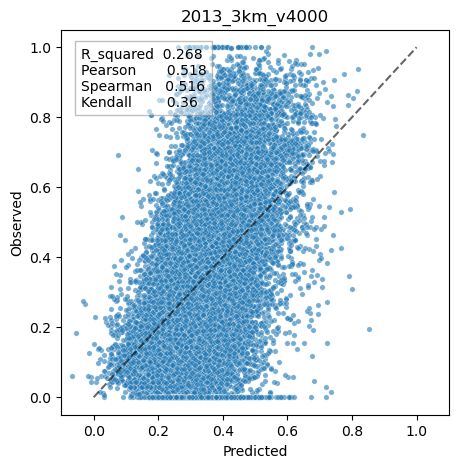

In [24]:
show_results(y_test, y_pred, file_name="scatter_"+data_label, title=data_label)

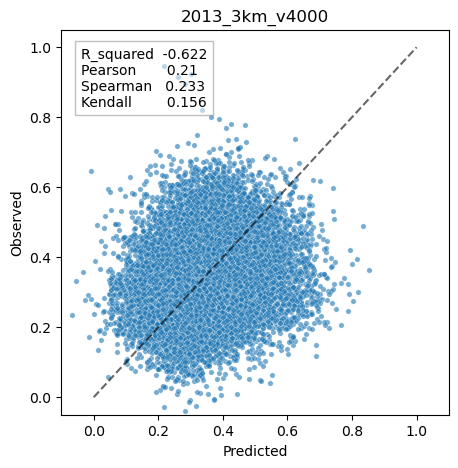

In [25]:
show_results(y_pred_21, y_pred, file_name="2013_v_21_scatter_"+data_label, title=data_label)

In [27]:
# min, max = 0.1, 0.6
# y_pred_scaled = ((y_pred - min) / (max - min))
# y_pred_21_scaled = ((y_pred_21 - min) / (max - min))
# show_results(y_test, y_pred_scaled, file_name="scatter_scaled_"+data_label, line=False, title=data_label+" (Scaled)")

Maps

In [28]:
# select dataframe with only test target and location data
gdf_clean_test_y = gdf_clean.iloc[test_index_common][geo_cols + [y_name]]

# add predicted values
gdf_clean_test_y.loc[:, "predicted"] = y_pred
# gdf_clean_test_y.loc[:, "predicted_scaled"] = y_pred_scaled
gdf_clean_test_y.loc[:, "predicted_21"] = y_pred_21


In [30]:
# import importlib
# import custom.evaluation
# importlib.reload(custom.evaluation)

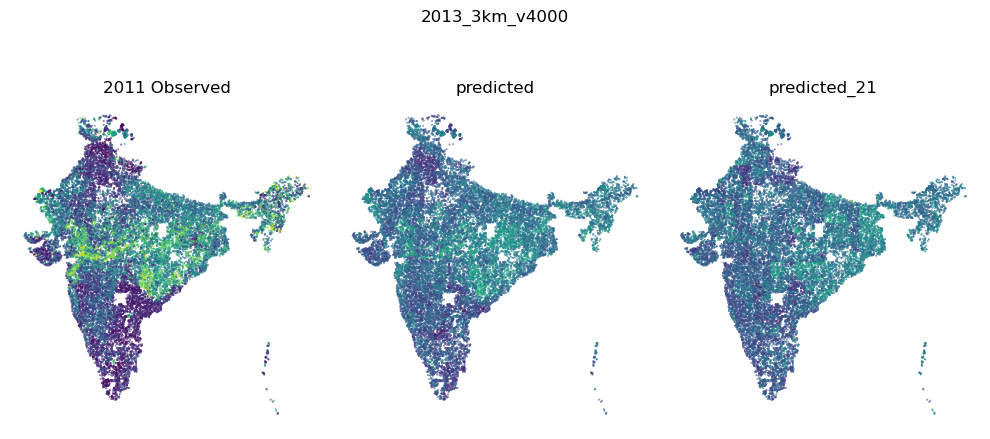

In [31]:
plot_prediction_maps(
    gdf=gdf_clean_test_y,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2013_v_21_maps_points_"+data_label,
    title=data_label,
    )

### Aggregate to `Subdistricts`

In [32]:
print("Total test datapoints: ", gdf_clean_test_y.shape[0])

Total test datapoints:  22619


In [33]:
sd_shapes = load_shrug_shapefiles(level="subdistrict")
sd_shapes["geometry_subdistrict"] = sd_shapes["geometry"]

In [34]:
gdf_clean_test_y_subdistricts = gdf_clean_test_y.sjoin(sd_shapes)

# change default geometry to subdistricts (for plotting)
gdf_clean_test_y_subdistricts["geometry_point"] = gdf_clean_test_y_subdistricts["geometry"]
gdf_clean_test_y_subdistricts["geometry"] = gdf_clean_test_y_subdistricts["geometry_subdistrict"]

In [35]:
subdistrict_ys = gdf_clean_test_y_subdistricts.groupby(
    [
        "pc11_state_id",
        "pc11_district_id",
        "pc11_subdistrict_id"
    ],
    as_index=False,
)[[y_name, "predicted", "predicted_21"]].mean()
print("Datapoints with unique subdistricts: ", subdistrict_ys.shape[0])

Datapoints with unique subdistricts:  4843


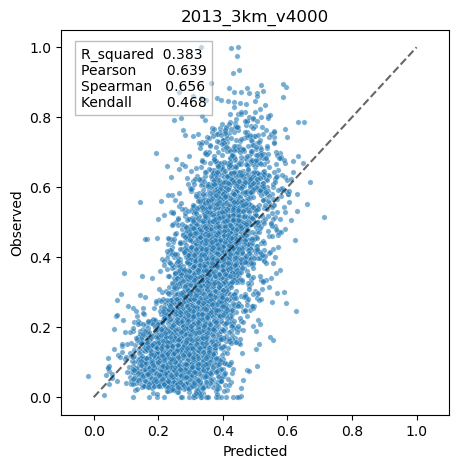

In [36]:
show_results(subdistrict_ys[y_name], subdistrict_ys["predicted"], file_name="scatter_subdistricts_"+data_label, title=data_label)

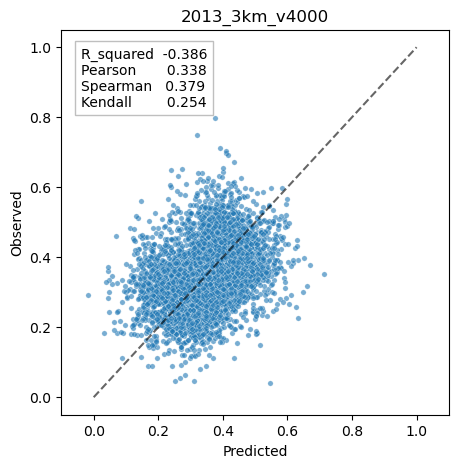

In [37]:
show_results(subdistrict_ys["predicted_21"], subdistrict_ys["predicted"], file_name="2013_v_21_scatter_subdistricts_"+data_label, title=data_label)

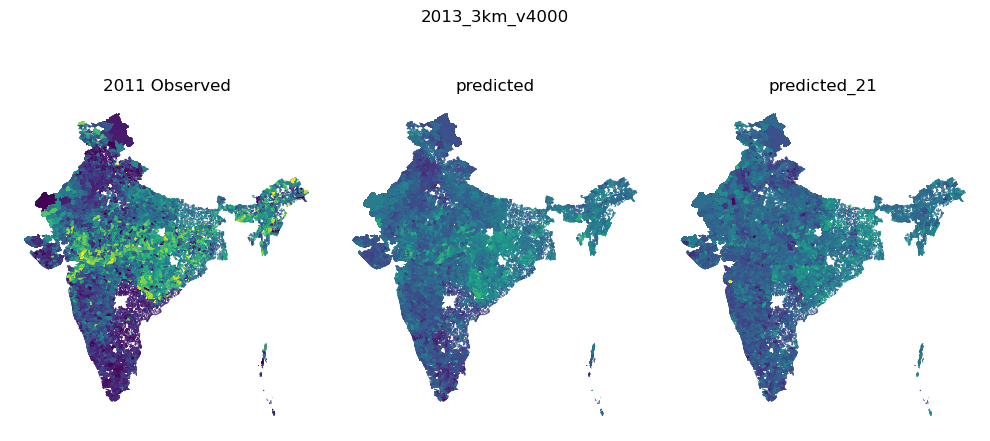

In [38]:
plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2013_v_21_maps_sd_"+data_label,
    title=data_label,
    )

#### Top 20% poorest subdistricts

In [39]:
gdf_clean_test_y_subdistricts[y_name+"top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts[y_name], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted"], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_21_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted_21"], q=5, labels=False) == 4) * 1

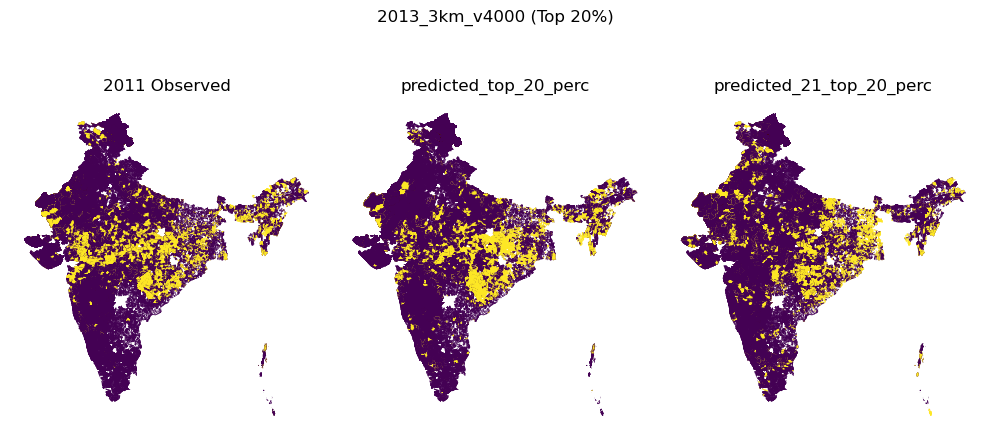

In [ ]:
plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name+"top_20_perc",
    y_pred_name="predicted_top_20_perc",
    y_pred_2_name="predicted_21_top_20_perc",
    vmin=0,
    vmax=1,
    file_name="2013_v_21_maps_sd_top20_"+data_label,
    title=data_label+" (Top 20%)",
    )

## [under construction]: 4 quadrant metrics


In [ ]:
pred_top_quintile = np.percentile(y_pred, [80])[0]
y_pred_is_top_quintile = list(y_pred > pred_top_quintile)

pred_21_top_quintile = np.percentile(y_pred_21, [80])[0]
y_pred_21_is_top_quintile = list(y_pred_21 > pred_top_quintile)

test_top_quintile = np.percentile(y_test, [80])[0]
y_test_is_top_quintile = list(y_test > test_top_quintile)

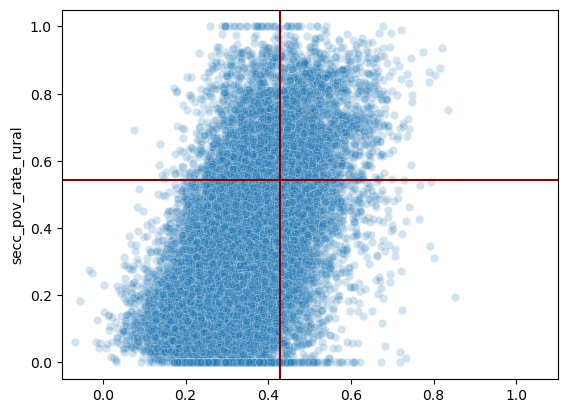

In [ ]:
sns.scatterplot(x=y_pred, y=y_test, alpha=0.2)
plt.xlim(-0.1, 1.1)
plt.axvline(pred_top_quintile, c="darkred")
plt.axhline(test_top_quintile, c="darkred")

In [ ]:
y_pred_is_NOT_top_quintile = [not b for b in y_pred_is_top_quintile]
y_test_is_NOT_top_quintile = [not b for b in y_test_is_top_quintile]

TP = sum(y_pred_is_top_quintile and y_test_is_top_quintile)
FP = sum(y_pred_is_top_quintile and y_test_is_NOT_top_quintile)
TN = sum(y_pred_is_NOT_top_quintile and y_test_is_NOT_top_quintile)
FN = sum(y_pred_is_NOT_top_quintile and y_test_is_top_quintile)

print(
    "TP: ", TP,
    "\nFP: ", FP,
    "\nTN: ", TN,
    "\nFN: ", FN
)

TP:  4524 
FP:  18095 
TN:  18095 
FN:  4524


In [49]:
cm_array = confusion_matrix(y_test_is_top_quintile, y_pred_is_top_quintile)
df_cm = pd.DataFrame(cm_array, [0,1], [0,1])

precision = round(precision_score(y_test_is_top_quintile, y_pred_is_top_quintile), 3)
recall = round(recall_score(y_test_is_top_quintile, y_pred_is_top_quintile), 3)

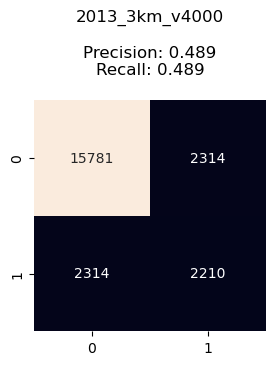

In [50]:
plt.figure(figsize=(3,3))
sns.heatmap(df_cm, annot=True, fmt='.5g', cbar=False)
plt.title(f"{data_label}\n\nPrecision: {precision}\nRecall: {recall}\n")
plt.savefig(DATA_ROOT+"/04_modeloutput/"+"confusion_matrix_"+data_label+".png")